In [1]:
import pandas as pd

In [2]:
from powerNetworkSolver import PowerNetworkSolver
from powerNetwork import networkTransform, getGenerators, getBuses, getLines,getNumBuses, getNumLines
from powerNetwork import getUndGraph, kron_reduction, edge_removing
from disturbancesGnr import normaldisturbances
from violationChecking import globalcheck
import seaborn as sns; sns.set_theme()
#importing the function for multi-edge removal
from powerNetwork import multi_edge_removing


In [14]:
import matplotlib.pyplot as plt

In [15]:

import numpy as np
import copy
from numpy.linalg import inv 
import networkx as nx
from numpy.random import multivariate_normal
from disturbancesGnr import normaldisturbances,correlated_disturbances
from scipy.integrate import odeint
from violationChecking import globalcheck
import math 
from functools import reduce




# 1. Test Case 39, complete network 

In [16]:
from pypower.api import case39

In [17]:
network39, subnetwork39 = networkTransform(case39())
df_lines39 = getLines(subnetwork39)
df_buses39 = getBuses(subnetwork39)

In [18]:
n39, ngnr39, unG39 = getUndGraph(df_buses39,df_lines39, network39)
A39, redL39, redA39  = kron_reduction(n39, ngnr39, unG39)
node_list =  np.arange(ngnr39)+1

#the previous adjacent matrix 
# redA39 = np.array([[0,2.484, 2.858, 2.372, 1.031, 0.222,2.13,13.057,3.676,7.834],
#               [2.484,0,10.494,1.781,0.774,0.166,1.599,1.473,0.903,5.885],
#               [2.858,10.494,0,2.522,1.096,0.236,2.264,1.729,1.144,4.772],
#               [2.372,1.781,2.522,0,17.136,0.535,5.14,1.699,1.755,1.367],
#               [1.031,0.774, 1.096,17.136,0 ,0.232, 2.235, 0.739, 0.763, 0.594],
#               [0.222,0.166,0.236,0.535,0.232,0,1.574, 0.159, 0.164, 0.128],
#               [2.13,1.599,2.264, 5.14, 2.235, 1.574, 0, 1.526, 1.576, 1.227],
#               [13.057,1.473,1.729, 1.699,0.739, 0.159, 1.526, 0, 4.283, 4.159],
#               [3.676, 0.903, 1.144, 1.755, 0.763, 0.164, 1.576, 4.283, 0, 1.37],
#               [7.834, 5.885, 4.772, 1.367, 0.594, 0.128, 1.227, 4.159, 1.37 ,0]])

# redA39 = np.ones((ngnr39,ngnr39))
# np.fill_diagonal(redA39, 0)
 

In [19]:
print(redL39)

[[ 32.19339596  -2.24077412  -2.53804929  -1.83375379  -0.84971196
   -1.97837115  -1.10734538 -11.4337488   -3.17111386  -7.0405276 ]
 [ -2.24077412  24.34176732  -9.78362621  -1.46126519  -0.6771108
   -1.57650656  -0.8824114   -1.33259746  -0.79623472  -5.59124086]
 [ -2.53804929  -9.78362621  25.7907586   -2.04017565  -0.94536227
   -2.20107229  -1.23199695  -1.53776482  -0.98920455  -4.52350657]
 [ -1.83375379  -1.46126519  -2.04017565  32.10610533 -15.62000109
   -4.7048095   -2.63340327  -1.32379253  -1.36949665  -1.11940767]
 [ -0.84971196  -0.6771108   -0.94536227 -15.62000109  23.25921633
   -2.18008159  -1.22024792  -0.61340969  -0.63458774  -0.51870327]
 [ -1.97837115  -1.57650656  -2.20107229  -4.7048095   -2.18008159
   30.63199579 -13.87777293  -1.42819225  -1.47750078  -1.20768875]
 [ -1.10734538  -0.8824114   -1.23199695  -2.63340327  -1.22024792
  -13.87777293  23.25554375  -0.79939605  -0.82699531  -0.67597456]
 [-11.4337488   -1.33259746  -1.53776482  -1.32379253  -

In [20]:
K = 1
M = np.array([0.2228, 0.1607, 0.1899, 0.1517, 0.1379, 0.1846, 0.1401, 0.1289, 0.183, 2.6526])
D = np.array([0.0332,0.076,0.0862,0.0838,0.0674,0.0862,0.0743,0.0716,0.1101,0.1333])
# Ome = np.zeros(n)
pi = math.pi
t =  2
nn = 100
dt = np.linspace(0, t, nn+1)

sigma = 0.01
theta0 = np.zeros(ngnr39)
omega0 = np.zeros(ngnr39)
OMEGA = np.zeros(ngnr39)
model39 = PowerNetworkSolver(theta0,omega0,redA39, ngnr39, D,M,K,OMEGA)

In [21]:
from numpy.random import seed

In [24]:
#generate numerical tracks 
seed(100)
disturbances = correlated_disturbances(delta=1, alpha=1.5, tau=1.5, n=ngnr39, L=redL39, k=1)
sol0 = np.pad(disturbances[0], (ngnr39,0), 'constant', constant_values=(0,0))
single_sol = model39.solkuramoto(sol0,dt)
sol_domega = model39.getDotOmega(single_sol[:,:ngnr39],single_sol[:,ngnr39:],nn)

Text(0.5, 1.0, 'Phase angles')

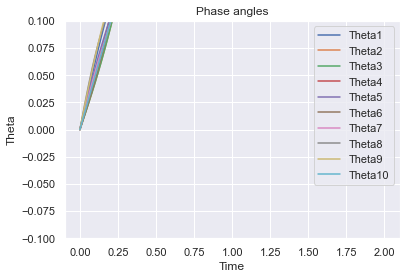

In [25]:
for i in range(ngnr39):
    theta = single_sol[:,i]
    plt.plot(dt, theta, "-", label="Theta"+ str(i+1))

plt.xlabel("Time")
plt.ylabel("Theta")    
plt.ylim(-0.1, 0.1)
plt.legend();
plt.title('Phase angles')

Text(0.5, 1.0, 'Natural rotation frequencies')

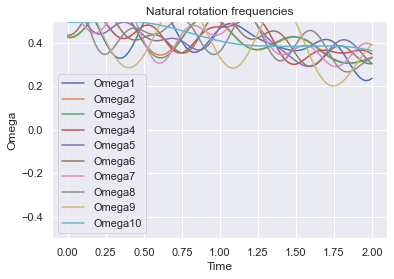

In [26]:
for i in range(ngnr39):
    omega = single_sol[:,ngnr39+i]  
    plt.plot(dt, omega, "-", label="Omega"+ str(i+1))


plt.xlabel("Time")

plt.ylabel("Omega")
plt.ylim(-0.5, 0.5)
plt.legend();
plt.title('Natural rotation frequencies')

Text(0.5, 1.0, 'Change Rates of Natural rotation frequencies')

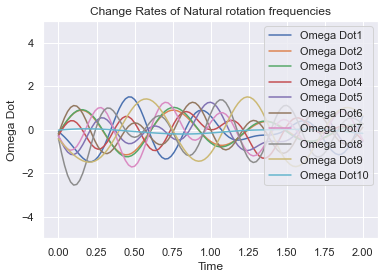

In [27]:
for i in range(ngnr39):
    domega = sol_domega[:,i]  
    plt.plot(dt, domega, "-", label="Omega Dot"+ str(i+1))

plt.xlabel("Time")
plt.ylabel("Omega Dot")
plt.ylim(-5, 5)
plt.legend();
plt.title('Change Rates of Natural rotation frequencies')

In [28]:
# simulation to calculate failure rates 
check_times = 100
KK =3000#repetition times  
thres = np.array([0.2,2])#thres1 is for omega, thres2 is for omega_dot
rates39 = model39.Simulation(KK, check_times, sigma, thres, t, nn, normaldisturbances)

In [29]:
print(rates39['totaltime'])

1.2e+02sec


In [32]:
df39 = pd.DataFrame({'Node': node_list,'RoCoF': rates39['vcheck_omega'] , 'AFV': rates39['vcheck_theta'] ,'AV': rates39['vcheck_any']})
print(df39.to_latex(index=False))

\begin{tabular}{rrrr}
\toprule
 Node &     RoCoF &       AFV &        AV \\
\midrule
    1 &  0.101000 &  0.177000 &  0.210667 \\
    2 &  0.156000 &  0.223667 &  0.259667 \\
    3 &  0.097667 &  0.196333 &  0.217333 \\
    4 &  0.237667 &  0.327333 &  0.397000 \\
    5 &  0.230000 &  0.363000 &  0.417333 \\
    6 &  0.164333 &  0.293333 &  0.341333 \\
    7 &  0.238000 &  0.357333 &  0.416000 \\
    8 &  0.277000 &  0.291333 &  0.384333 \\
    9 &  0.022667 &  0.268000 &  0.268000 \\
   10 &  0.000000 &  0.046667 &  0.046667 \\
\bottomrule
\end{tabular}



In [34]:
df39.to_excel('original_network_cor.xlsx')

In [17]:
test=pd.DataFrame()

network_test = multi_edge_removing(unG39, [[15,16],[20,34],[23,24]])

# 2. Test Case 39, incomplete networks

## 2.1 Removing (20, 34)

## 2.2 Removing (15, 16)

## 2.3 Removing (23, 24)

In [ ]:
pd.options.display.float_format = '{:,.3f}'.format
df39.head()

## 2.4 Removing [4, 5],[15, 16]

## 2.5 Removing [4, 5],[15, 16],[4, 14]

In [35]:
G3905 = multi_edge_removing(unG39, ([4,5],[15,16],[4,14]))
A3905, redL3905, redA3905  = kron_reduction(n39, ngnr39, G3905)
model3905 = PowerNetworkSolver(theta0,omega0,redA3905, ngnr39, D,M,K,OMEGA)
rates3905 = model3905.Simulation(KK, check_times, sigma, thres, t, nn, normaldisturbances)

[4, 5]
[15, 16]
[4, 14]


In [36]:
df3905 = pd.DataFrame({'Node': node_list,'RoCoF': rates3905['vcheck_omega'] , 'AFV': rates3905['vcheck_theta'] ,'AV': rates3905['vcheck_any']})

In [37]:
df39_merged02 = [df39,df3905]
df39merged02 = reduce(lambda  left,right: pd.merge(left,right,on=['Node'],
                                            how='outer'), df39_merged02)
df39merged02 = df39merged02.append(df39merged02.mean(axis = 0), ignore_index=True)
# print(df39merged02.to_latex(index=False))
df39merged02.to_excel('tuple_cor_cov.xlsx')

## 2.6 Removing [4, 5]

## 2.7 Removing [4, 14]

## 2.8 All single-edge removals 

In [39]:
# show edge list
# print
edge_list39 = list(unG39.edges)
num_edges39 = getNumLines(getLines(subnetwork39))
rate_list39 = np.zeros((num_edges39,4))
# print()
j=0
for i in edge_list39:
    temp_edge = np.array(i)
    temp_G39 = edge_removing(unG39, temp_edge)
    temp_A39, temp_redL39,temp_redA39 = kron_reduction(n39,ngnr39,temp_G39)
    temp_model39 = PowerNetworkSolver(theta0,omega0,temp_redA39,ngnr39,D,M,K,OMEGA)
    temp_rates39 = temp_model39.Simulation(KK, check_times, sigma, thres, t, nn, normaldisturbances)
    temp_df39 = pd.DataFrame({'Node': node_list,'RoCoF': temp_rates39['vcheck_omega'] , 'AFV': temp_rates39['vcheck_theta'] ,'AV': temp_rates39['vcheck_any']})
    rate_list39[j,:]=temp_df39.mean(axis = 0)
    j+=1
    
    

The graph is not connected without edge (2.0, 30.0)


KeyboardInterrupt: 

In [55]:
type(edge_list39[0])

tuple

In [ ]:
single_edge_rate39 = pd.DataFrame({'Edge List':edge_list39, 'RoCoF':rate_list39[:,1],'AFV':rate_list39[:,2],'AV':rate_list39[:,3]})

In [ ]:
single_edge_rate39.head()

In [ ]:
single_edge_rate39.to_excel('Single_edge_rate39.xlsx')
# print(single_edge_rate39.to_latex(index=False))

# 3. Correlated Disturbances 

In [21]:
from disturbancesGnr import normaldisturbances
from disturbancesGnr import correlated_disturbances
from numpy.linalg import matrix_power
from scipy.linalg import fractional_matrix_power


In [46]:
# np.set_printoptions(precision=3)
# np.set_printoptions(edgeitems=3, infstr='inf',linewidth=75, nanstr='nan', precision=8,suppress=False, threshold=1000, formatter=None)
# print(redL39)
# rounded_redL39 = np.round(redL39,3)
# print(np.sum(rounded_redL39,axis=0))
np.fill_diagonal(redL39,0)
row_sum = -np.sum(redL39,axis = 0)
np.fill_diagonal(redL39,row_sum)
print(redL39)

[[ 32.19339596  -2.24077412  -2.53804929  -1.83375379  -0.84971196
   -1.97837115  -1.10734538 -11.4337488   -3.17111386  -7.0405276 ]
 [ -2.24077412  24.34176732  -9.78362621  -1.46126519  -0.6771108
   -1.57650656  -0.8824114   -1.33259746  -0.79623472  -5.59124086]
 [ -2.53804929  -9.78362621  25.7907586   -2.04017565  -0.94536227
   -2.20107229  -1.23199695  -1.53776482  -0.98920455  -4.52350657]
 [ -1.83375379  -1.46126519  -2.04017565  32.10610533 -15.62000109
   -4.7048095   -2.63340327  -1.32379253  -1.36949665  -1.11940767]
 [ -0.84971196  -0.6771108   -0.94536227 -15.62000109  23.25921633
   -2.18008159  -1.22024792  -0.61340969  -0.63458774  -0.51870327]
 [ -1.97837115  -1.57650656  -2.20107229  -4.7048095   -2.18008159
   30.63199579 -13.87777293  -1.42819225  -1.47750078  -1.20768875]
 [ -1.10734538  -0.8824114   -1.23199695  -2.63340327  -1.22024792
  -13.87777293  23.25554375  -0.79939605  -0.82699531  -0.67597456]
 [-11.4337488   -1.33259746  -1.53776482  -1.32379253  -

In [47]:
delta = 1
alpha = 1.5
tau = 1.5
L = redL39
# L = L_test
n = ngnr39
test = delta*(tau**(2*alpha))*fractional_matrix_power(L+(tau**2)*np.eye(n),-alpha)
print(test)

[[0.11683256 0.09854813 0.09841607 0.09415556 0.09264244 0.09483424
  0.0936338  0.10713023 0.10043004 0.10337694]
 [0.09854813 0.12425345 0.10794804 0.09403561 0.09250102 0.09472051
  0.09350166 0.09711391 0.0937572  0.10362046]
 [0.09841607 0.10794804 0.12167297 0.09496997 0.09348553 0.09564126
  0.09446585 0.09707669 0.09406861 0.102255  ]
 [0.09415556 0.09403561 0.09496997 0.12098356 0.11508075 0.10093898
  0.09995194 0.09345621 0.09322123 0.09320618]
 [0.09264244 0.09250102 0.09348553 0.11508075 0.13276828 0.09971048
  0.09860383 0.09190418 0.09166727 0.09163621]
 [0.09483424 0.09472051 0.09564126 0.10093898 0.09971048 0.12000795
  0.11218999 0.09414545 0.0939107  0.09390043]
 [0.0936338  0.09350166 0.09446585 0.09995194 0.09860383 0.11218999
  0.12941604 0.09291132 0.09267476 0.09265082]
 [0.10713023 0.09711391 0.09707669 0.09345621 0.09190418 0.09414545
  0.09291132 0.12231181 0.10229513 0.10165507]
 [0.10043004 0.0937572  0.09406861 0.09322123 0.09166727 0.0939107
  0.09267476 